In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
from pathlib import Path
import off_sample as utils

Using TensorFlow backend.


In [3]:
%run off_sample/utils.py

In [4]:
image_shape = (64, 64, 1)
data_path = Path('./GS/raw_images_rect/')

# Check Hardware and Tools

In [5]:
import tensorflow as tf

In [6]:
tf.__version__

'1.10.1'

In [7]:
from tensorflow.python.client import device_lib

In [8]:
for d in device_lib.list_local_devices():
    print(d)

name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7950389851888842215

name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11279997338
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3893615565078330618
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"



In [9]:
from skimage import transform
import imageio
import keras
import numpy as np
import pandas as pd
import sklearn
import matplotlib
keras.__version__, pd.__version__, np.__version__, matplotlib.__version__, sklearn.__version__

('2.2.2', '0.20.2', '1.13.3', '2.0.2', '0.19.2')

In [10]:
from matplotlib import pyplot as plt
%matplotlib inline

# Data Generators

In [11]:
import random

In [12]:
def read_resize(img_path):
    img = imageio.imread(img_path)[:,:,0]
    img = transform.resize(img, image_shape, mode='constant')
    img = img / img.max()
    return img

In [13]:
X_list, y_list, groups = [], [], []

for ds_path in data_path.iterdir():
    for img_class in ['on', 'off']:
        for img_path in (ds_path / img_class).iterdir():
            img = read_resize(img_path)

            X_list.append(img)
            y_list.append(1 if img_class == 'off' else 0)
            groups.append(ds_path.name)

X = np.stack(X_list)
X.setflags(write=False)

y = np.stack(y_list)
y = y.reshape(y.shape + (1,))
y = keras.utils.to_categorical(y, 2)
y.setflags(write=False)

groups = np.stack(groups)
groups.setflags(write=False)

X.shape, y.shape, groups.shape

((18245, 64, 64, 1), (18245, 2), (18245,))

In [14]:
(y[:,0] == 1).sum()

10010

In [15]:
u_groups = np.unique(groups)
len(u_groups)

67

In [16]:
%run off_sample/utils.py

# Train and Test Model

In [17]:
import pickle
import keras
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_curve, roc_auc_score, accuracy_score, f1_score,
                             precision_score, recall_score, average_precision_score)

In [18]:
other_u_groups, test_u_groups = train_test_split(u_groups, test_size=0.2, random_state=13)
other_u_groups.shape, test_u_groups.shape

((53,), (14,))

In [19]:
X_other, y_other, groups_other = make_subset(other_u_groups, X, y, groups)
X_test, y_test, groups_test = make_subset(test_u_groups, X, y, groups)

In [20]:
train_u_groups, valid_u_groups = train_test_split(other_u_groups, test_size=0.3, random_state=13)
train_u_groups.shape, valid_u_groups.shape

((37,), (16,))

### Dataset Sampling

In [21]:
X_sample_list = []
y_sample_list = []
groups_sample_list = []

for g in other_u_groups:
    g_off = (groups_other == g)&(y_other[:,1] == 1)
    g_on = (groups_other == g)&(y_other[:,1] == 0)
    
    on_inds = np.arange(X_other[g_on].shape[0])
    on_sample_inds = np.random.choice(on_inds, int(round(on_inds.shape[0] / 5)), replace=False)
    off_inds = np.arange(X_other[g_off].shape[0])
    off_sample_inds = np.random.choice(off_inds, int(round(off_inds.shape[0] / 5)), replace=False)
    
    X_sample_list.append(np.concatenate([X_other[g_on][on_sample_inds],
                                         X_other[g_off][off_sample_inds]]))
    y_sample_list.append(np.concatenate([y_other[g_on][on_sample_inds],
                                         y_other[g_off][off_sample_inds]]))
    groups_sample_list.append(np.concatenate([groups_other[g_on][on_sample_inds],
                                              groups_other[g_off][off_sample_inds]]))

X_sample = np.concatenate(X_sample_list)
X_sample.setflags(write=False)
y_sample = np.concatenate(y_sample_list)
y_sample.setflags(write=False)
groups_sample = np.concatenate(groups_sample_list)
groups_sample.setflags(write=False)

In [22]:
X_other.shape, X_sample.shape

((14543, 64, 64, 1), (2908, 64, 64, 1))

In [135]:
class OffSampleImageDataGenerator(ImageDataGenerator):

    def standardize(self, x):
        return super().standardize(x.copy())

In [136]:
import math

def step_decay(epoch):
    initial_rate = 1e-4
    drop = 0.5
    epochs_drop = 15
    lr = initial_rate * math.pow(drop, math.floor(epoch / epochs_drop))
    return lr
# [step_decay(i) for i in range(30)]

In [137]:
data_gen = OffSampleImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=0.3)

In [138]:
# validator.best_params_

In [1]:
%%time
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.optimizers import Adam

batch_size = 32
epochs = 30
params = {
    'opt': Adam(lr=1e-4),
    'l1_a': 0,
    'l2_a': 0.1,
    'dense_fn': (256, 256),
}

verbose = 1
attempts = 3

metrics_list, history_list = [], []

for i in range(attempts):
    print(f'Attempt: {i}')
    
    X_train, y_train, _ = make_subset(train_u_groups, X_sample, y_sample, groups_sample)
    X_valid, y_valid, _ = make_subset(valid_u_groups, X_sample, y_sample, groups_sample)
#     X_train, y_train, _ = make_subset(train_u_groups, X, y, groups)
#     X_valid, y_valid, _ = make_subset(valid_u_groups, X, y, groups)
     
    data_gen.fit(X_train)
    X_valid = data_gen.standardize(X_valid)

    lr_scheduler = LearningRateScheduler(step_decay, verbose=1)
    check_pointer = ModelCheckpoint(f'./weights.best.{i}.hdf5', monitor='val_binary_accuracy',
                                    save_best_only=False)
    model = create_model(metrics=['binary_accuracy'], **params)
    history = model.fit_generator(data_gen.flow(X_train, y_train, batch_size=batch_size),
                                  validation_data=(X_valid, y_valid),
                                  steps_per_epoch=X_train.shape[0]/batch_size,
                                  epochs=epochs, verbose=verbose,
                                  callbacks=[check_pointer])
    history_list.append(history.history)

    y_pred = model.predict(X_valid, verbose=verbose)
    metrics = calc_metrics(y_valid, y_pred)
    metrics['attempt'] = i
    metrics_list.append(metrics)

    print(metrics)
    print()

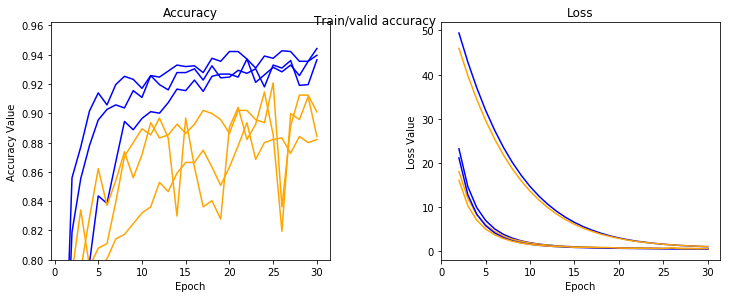

In [215]:
plot_learning_graph(history_list, attempts)

In [216]:
X_test, y_test, _ = make_subset(test_u_groups, X, y, groups)
evaluate_model(X_test, y_test, model, data_gen)

3702/3702 [==============================] - 1s 302us/step


,f1,prec_recall_score,prec,recall,acc
on,0.948581,0.994993,0.910540,0.989939,0.948136
off,0.947684,0.993784,0.989755,0.909043,0.948136


In [217]:
for i in range(attempts):
    print(i)
    model.load_weights(filepath=f'weights.best.{i}.hdf5')
    X_test, y_test, _ = make_subset(test_u_groups, X, y, groups)
    df = evaluate_model(X_test, y_test, model, data_gen)
    print(df)

0
3702/3702 [==============================] - 1s 301us/step
           f1  prec_recall_score      prec    recall       acc
on   0.938847           0.989872  0.979939  0.901062  0.943274
off  0.947103           0.990388  0.913952  0.982750  0.943274
1
3702/3702 [==============================] - 1s 301us/step
           f1  prec_recall_score      prec    recall       acc
on   0.971014           0.995545  0.968316  0.973728  0.971907
off  0.972746           0.993923  0.975302  0.970204  0.971907
2
3702/3702 [==============================] - 1s 301us/step
           f1  prec_recall_score      prec    recall       acc
on   0.948581           0.994993  0.910540  0.989939  0.948136
off  0.947684           0.993784  0.989755  0.909043  0.948136


In [218]:
y_test_pred = 0
for i in range(attempts):
    X_test, y_test, _ = make_subset(test_u_groups, X, y, groups)
    X_test = data_gen.standardize(X_test)
    model.load_weights(filepath=f'weights.best.{i}.hdf5')
    y_test_pred += model.predict_proba(X_test, verbose=1)
y_test_pred /= attempts
calc_metrics(y_test, y_test_pred)

3702/3702 [==============================] - 1s 299us/step


,f1,prec_recall_score,prec,recall,acc
on,0.978865,0.995407,0.973990,0.983790,0.979471
off,0.980042,0.994231,0.984697,0.975431,0.979471


In [196]:
y_test_pred = 0
for i in range(attempts):
    X_test, y_test, _ = make_subset(valid_u_groups, X, y, groups)
    X_test = data_gen.standardize(X_test)
    model.load_weights(filepath=f'weights.best.{i}.hdf5')
    y_test_pred += model.predict_proba(X_test, verbose=1)
y_test_pred /= attempts
calc_metrics(y_test, y_test_pred)

4779/4779 [==============================] - 1s 244us/step


,f1,prec_recall_score,prec,recall,acc
on,0.804428,0.968858,0.993490,0.675819,0.844737
off,0.871270,0.972455,0.774283,0.996033,0.844737


In [296]:
# X_valid, y_valid, _ = make_subset(valid_u_groups, X, y, groups)
# X_valid = data_gen.standardize(X_valid)
# y_valid_pred = model.predict(X_valid, verbose=verbose)
# valid_metrics = calc_metrics(y_valid,y_valid_pred)
# valid_metrics

### Define Model

In [219]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from keras.losses import binary_crossentropy
from keras.callbacks import EarlyStopping
from keras.regularizers import l2, l1_l2
from keras.optimizers import SGD, Adam, Nadam, Adamax, Adadelta
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from collections import OrderedDict
import math
from keras.metrics import binary_accuracy
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import f1_score

image_shape = (64, 64, 1)


def create_model(opt=None,
                 l1_a=0.01, l2_a=0.01,
                 init_filters=8,
                 dropout_p=0.5,
                 dense_fn=(256, 256),
                 act_f='relu',
                 kernel_initializer='glorot_uniform',
                 metrics=None):
    model = Sequential()

    strides = (1, 1)
    pool_size = (2, 2)

    model.add(Conv2D(init_filters, (3, 3), strides=strides, padding='same', input_shape=image_shape,
                     kernel_initializer=kernel_initializer, kernel_regularizer=l1_l2(l1_a, l2_a)))
    model.add(BatchNormalization())
    model.add(Activation(act_f))
    model.add(MaxPool2D(pool_size=pool_size))

    model.add(Conv2D(init_filters, (3, 3), strides=strides, padding='same',
                     kernel_initializer=kernel_initializer, kernel_regularizer=l1_l2(l1_a, l2_a)))
    model.add(BatchNormalization())
    model.add(Activation(act_f))
    model.add(MaxPool2D(pool_size=pool_size))

    model.add(Conv2D(init_filters * 2, (3, 3), strides=strides, padding='same',
                     kernel_initializer=kernel_initializer, kernel_regularizer=l1_l2(l1_a, l2_a)))
    model.add(BatchNormalization())
    model.add(Activation(act_f))
    model.add(MaxPool2D(pool_size=pool_size))

    model.add(Conv2D(init_filters * 4, (3, 3), strides=strides, padding='same',
                     kernel_initializer=kernel_initializer, kernel_regularizer=l1_l2(l1_a, l2_a)))
    model.add(BatchNormalization())
    model.add(Activation(act_f))
    model.add(MaxPool2D(pool_size=pool_size))

    model.add(Conv2D(init_filters * 8, (3, 3), strides=strides, padding='same',
                     kernel_initializer=kernel_initializer, kernel_regularizer=l1_l2(l1_a, l2_a)))
    model.add(BatchNormalization())
    model.add(Activation(act_f))
    model.add(MaxPool2D(pool_size=pool_size))

    model.add(Conv2D(init_filters * 16, (2, 2), strides=strides, padding='valid',
                     kernel_initializer=kernel_initializer, kernel_regularizer=l1_l2(l1_a, l2_a)))
    model.add(BatchNormalization())
    model.add(Activation(act_f))

    model.add(Flatten())

    model.add(Dense(dense_fn[0], kernel_initializer=kernel_initializer, kernel_regularizer=l1_l2(l1_a, l2_a)))
    model.add(Activation(act_f))
    model.add(Dropout(dropout_p))

    model.add(Dense(dense_fn[1], kernel_initializer=kernel_initializer, kernel_regularizer=l1_l2(l1_a, l2_a)))
    model.add(Activation(act_f))
    model.add(Dropout(dropout_p))

    model.add(Dense(2, kernel_initializer=kernel_initializer, kernel_regularizer=l1_l2(l1_a, l2_a)))
    model.add(Activation('softmax'))

    if not metrics:
        metrics = [binary_accuracy]
    model.compile(loss=binary_crossentropy,
                  optimizer=opt,
                  metrics=metrics)
    return model


import copy
from keras.preprocessing.image import ImageDataGenerator


class OffSampleImageDataGenerator(ImageDataGenerator):

    def standardize(self, x):
        return super(OffSampleImageDataGenerator, self).standardize(x.copy())


class OffSampleKerasClassifier(KerasClassifier):

    def __init__(self, **sk_params):
        super().__init__(**sk_params)
        self.classes_ = np.arange(2)

    def check_params(self, params):
        pass

    def fit(self, x, y, **kwargs):
        self.set_params(**kwargs)

        print('create_model args: {}'.format(self.filter_sk_params(create_model)))
        self.model = create_model(**self.filter_sk_params(create_model))

        self.data_gen = OffSampleImageDataGenerator(
            featurewise_center=True,
            featurewise_std_normalization=True,
            rotation_range=30,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            rescale=0.3)
        self.data_gen.fit(x)

        print('fit_generator args: {}'.format(self.filter_sk_params(Sequential.fit_generator)))
        fit_args = copy.deepcopy(self.filter_sk_params(Sequential.fit_generator))
        fit_args.update(kwargs)
        print('flow args: {}'.format(self.filter_sk_params(ImageDataGenerator.flow)))
        flow_args = copy.deepcopy(self.filter_sk_params(ImageDataGenerator.flow))

        history = self.model.fit_generator(self.data_gen.flow(x, y, **flow_args),
                                           **fit_args)
        return history

    def _target_class_f1_score(self, x, y, **kwargs):
        x = self.data_gen.standardize(x)
        y_pred = self.model.predict(x)
        y_pred_lab = np.around(y_pred)
        return f1_score(y[:, 1], y_pred_lab[:, 1])  # 0 - on, 1 - off

    def score(self, x, y, **kwargs):
        return self._target_class_f1_score(x, y, **kwargs)

    def predict_proba(self, x, **kwargs):
        x = self.data_gen.standardize(x)
        return KerasClassifier.predict_proba(self, x, **kwargs)

# Hyperparameters Random Search

In [198]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.model_selection import GroupKFold

In [199]:
# other_u_groups_sample = other_u_groups[:10]
# train_u_groups_sample, valid_u_groups_sample = train_u_groups[:5], valid_u_groups[:2]
# other_u_groups_sample, train_u_groups_sample, valid_u_groups_sample

In [200]:
# X_other, y_other, groups_other = make_subset(other_u_groups, X_sample, y_sample, groups_sample)
# X_train, y_train, groups_train = make_subset(train_u_groups_sample, X, y, groups)
# X_valid, y_valid, groups_valid = make_subset(valid_u_groups_sample, X, y, groups)

In [201]:
params_dist = {
#     'batch_size': [16, 32, 64],
    'batch_size': [32],
#     'epochs': [5, 10, 15, 20, 25, 30],
    'epochs': [30],
#     'opt': [Adam(lr=1e-4), Nadam(lr=2e-3), Adamax(lr=2e-3), Adadelta(lr=1.0)],
    'opt': [Adam(lr=1e-4)],
#     'opt_alg': [Adam, Nadam, Adamax, Adadelta],
#     'opt_lr': [1e-3, 1e-4, 2e-4, 1e-5],
#     'opt_lr': [5e-5],
#     'l1_a': [1e-1, 1e-2, 1e-3, 1e-4, 0],
#     'l2_a': [1e-1, 1e-2, 1e-3, 1e-4, 0],
    'l1_a': [0],
    'l2_a': [1e-1],
#     'init_filters': [2, 4, 8, 16],
    'init_filters': [8],
#     'dropout_p': [0, 0.25, 0.5, 0.75],
    'dropout_p': [0.5],
#     'dense_fn': [(128, 128), (128, 256), (256, 256), (256, 512), (512, 512)],
    'dense_fn': [(128, 128)],
#     'act_f': ['relu', 'elu', 'selu'],
    'act_f': ['relu'],
#     'kernel_initializer': ['he_uniform', 'he_normal', 'lecun_uniform', 'lecun_normal',
#                            'glorot_uniform', 'glorot_normal']
    'kernel_initializer': ['glorot_uniform']
}

In [202]:
def get_comb_n(params_dist):
    comb_n = 1
    for p, vals in params_dist.items():
        comb_n *= len(vals)
    return comb_n
get_comb_n(params_dist)

5

In [203]:
# def make_cv_gen(train_u_groups, valid_u_groups, groups_sample, n=2):
#     for _ in range(n):
#         train_mask = np.array([g in train_u_groups for g in groups_sample])
#         valid_mask = np.array([g in valid_u_groups for g in groups_sample])
#         yield train_mask, valid_mask
def make_cv_gen(X, y, groups, n=4):
    groupkfold = GroupKFold(n)
    return groupkfold.split(X, y, groups)

In [4]:
%%time
max_iter = 100
kclf = OffSampleKerasClassifier()
# cv_gen = make_cv_gen(train_u_groups, valid_u_groups, groups_sample, n=1)
cv_gen = make_cv_gen(X_sample, y_sample, groups_sample, n=3)
validator = RandomizedSearchCV(kclf, param_distributions=params_dist,
                               n_iter=min(get_comb_n(params_dist), max_iter),
                               n_jobs=1, cv=cv_gen, random_state=13)
validator.fit(X_sample, y_sample);

In [205]:
validator.best_params_, validator.best_score_, validator.cv_results_['rank_test_score']

({'act_f': 'relu',
  'batch_size': 32,
  'dense_fn': (128, 128),
  'dropout_p': 0.5,
  'epochs': 30,
  'init_filters': 8,
  'kernel_initializer': 'glorot_uniform',
  'l1_a': 0,
  'l2_a': 0.1,
  'opt': <keras.optimizers.Adam at 0x7f6b48318828>},
 0.91475369415237318,
 array([1, 4, 3, 2, 5], dtype=int32))

In [206]:
from copy import deepcopy, copy

In [207]:
rows = []
for f1_mean, f1_std, params in  zip(validator.cv_results_['mean_test_score'],
                                    validator.cv_results_['std_test_score'],
                                    validator.cv_results_['params']):
    row = copy(params)
    row['opt'] = params['opt'].__class__.__name__
    row.update({'f1_mean': f1_mean, 'f1_std': f1_std})
    rows.append(row)
grid_df = pd.DataFrame(rows).sort_values(by='f1_mean', ascending=False)
grid_df

,act_f,batch_size,dense_fn,dropout_p,epochs,f1_mean,f1_std,init_filters,kernel_initializer,l1_a,l2_a,opt
0,relu,32,"(128, 128)",0.5,30,0.914754,0.026403,8,glorot_uniform,0,0.1,Adam
3,relu,32,"(256, 512)",0.5,30,0.913325,0.028476,8,glorot_uniform,0,0.1,Adam
2,relu,32,"(256, 256)",0.5,30,0.904736,0.020757,8,glorot_uniform,0,0.1,Adam
1,relu,32,"(128, 256)",0.5,30,0.890959,0.014840,8,glorot_uniform,0,0.1,Adam
4,relu,32,"(512, 512)",0.5,30,0.882411,0.017956,8,glorot_uniform,0,0.1,Adam


In [208]:
# %run off_sample/utils.py
X_test, y_test, _ = make_subset(test_u_groups, X, y, groups)
evaluate_model(X_test, y_test, validator.best_estimator_)

3702/3702 [==============================] - 11s 3ms/step


,f1,prec_recall_score,prec,recall,acc
on,0.637747,0.993540,0.998808,0.468418,0.742842
off,0.800670,0.993121,0.667831,0.999477,0.742842


---

# Final Model Cross Validation

In [221]:
data_gen = OffSampleImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=0.3)

In [231]:
batch_size = 32
epochs = 15
params = {
    'opt': Adam(lr=5e-5),
    'l1_a': 0,
    'l2_a': 0.1,
    'dense_fn': (256, 256),
}

In [5]:
%%time
folds = 5
break_after_first_fold = False
attempts = 5

cv_metrics = []
history_list = []

gkfold = GroupKFold(n_splits=folds)
for fold_i, (train_inds, valid_inds) in enumerate(gkfold.split(X, y, groups)):
    print(f'Fold: {fold_i}', train_inds.shape, valid_inds.shape)
    
    X_train, y_train = X[train_inds], y[train_inds]
    X_valid, y_valid = X[valid_inds], y[valid_inds]
    
    data_gen.fit(X_train)
    X_valid = data_gen.standardize(X_valid)
    
    y_pred_avg = np.zeros(y_valid.shape)
    for i in range(attempts):
        print(f'Attempt: {i}')
#         lr_scheduler = LearningRateScheduler(step_decay, verbose=1)
        model = create_model(metrics=['binary_accuracy'], **params)
        history = model.fit_generator(data_gen.flow(X_train, y_train, batch_size=batch_size),
                                      validation_data=(X_valid, y_valid),
                                      steps_per_epoch=X_train.shape[0]/batch_size,
                                      epochs=epochs, verbose=verbose,
                                      callbacks=[])
        history_list.append(history.history)

        y_pred = model.predict(X_valid, verbose=verbose)
        y_pred_avg += y_pred
        metrics = calc_metrics(y_valid, y_pred)
        metrics['fold'] = fold_i
        metrics['attempt'] = i
        cv_metrics.append(metrics)

        print(metrics)
        print()
    
    print('Averaged')
    y_pred_avg /= attempts
    metrics = calc_metrics(y_valid, y_pred_avg)
    metrics['fold'] = fold_i
    metrics['attempt'] = 'avg'
    cv_metrics.append(metrics)  
    print(metrics)
    print()

    if break_after_first_fold:
        break

metrics_df = pd.concat(cv_metrics)
metrics_df.to_msgpack('metrics_df.msgpack')
pickle.dump(history_list, open('history_list.pkl', 'wb'))

In [225]:
# metrics_df = pd.concat(cv_metrics)

In [253]:
df = metrics_df[metrics_df.attempt == 'avg']
df[['f1', 'prec', 'recall', 'acc']].groupby(df.index).agg([np.mean, np.std])

f1                prec              recall                 acc  \
         mean       std      mean       std      mean       std      mean   
off  0.951942  0.017984  0.945239  0.041833  0.960116  0.019527  0.956549   
on   0.960183  0.014291  0.966602  0.016853  0.954793  0.034627  0.956549   

              
         std  
off  0.01583  
on   0.01583

In [251]:
# df = metrics_df #[metrics_df.attempt == 'avg']
# df.groupby(df.index).agg([np.mean, np.std])

In [343]:
# metrics_df[['f1', 'precision', 'recall']].groupby(metrics_df.index).agg((np.mean, np.std))

In [237]:
df = metrics_df.loc['off']
df[df.attempt != 'avg'][['f1', 'prec', 'recall', 'fold', 'attempt']]

,f1,prec,recall,fold,attempt
off,0.940616,0.953638,0.927945,0,0
off,0.952949,0.954146,0.951754,0,1
off,0.956140,0.956140,0.956140,0,2
off,0.969641,0.958946,0.980576,0,3
off,0.968415,0.948348,0.989348,0,4
off,0.940830,0.969072,0.914188,1,0
off,0.944046,0.947035,0.941076,1,1
off,0.956596,0.954960,0.958238,1,2
off,0.941602,0.916126,0.968535,1,3
off,0.888191,0.984680,0.808924,1,4


In [238]:
metrics_df.loc['on']

,f1,prec_recall_score,prec,recall,acc,fold,attempt
on,0.954446,0.993672,0.944552,0.964549,0.948442,0,0
on,0.963109,0.993018,0.962162,0.964057,0.958644,0,1
on,0.965534,0.995055,0.965534,0.965534,0.961401,0,2
on,0.975658,0.997001,0.984461,0.967011,0.972980,0,3
on,0.974205,0.997375,0.991335,0.957656,0.971602,0,4
on,0.974016,0.996935,0.979104,0.968981,0.971050,0,avg
on,0.949075,0.993585,0.925853,0.973493,0.945261,1,0
on,0.949469,0.992275,0.946770,0.952183,0.946895,1,1
on,0.960437,0.994556,0.961940,0.958940,0.958606,1,2
on,0.943970,0.987799,0.969846,0.919439,0.942810,1,3


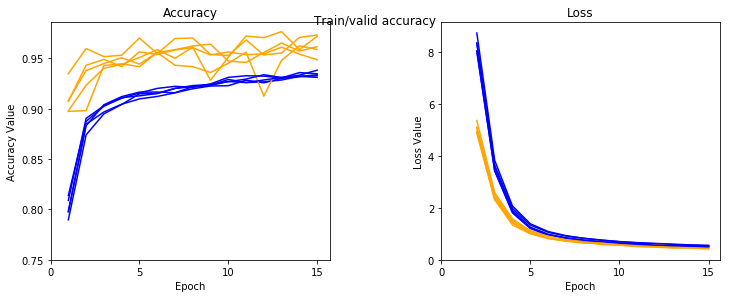

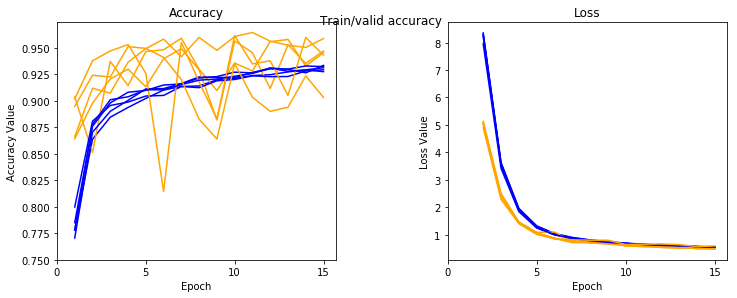

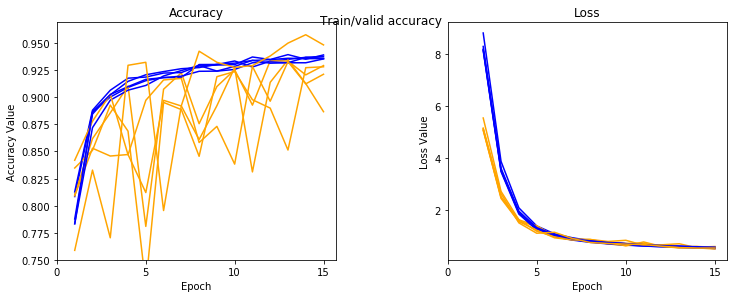

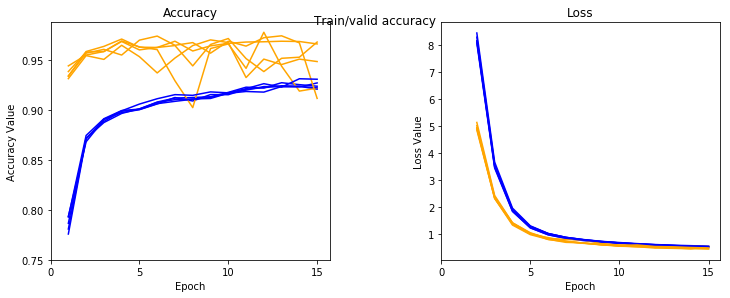

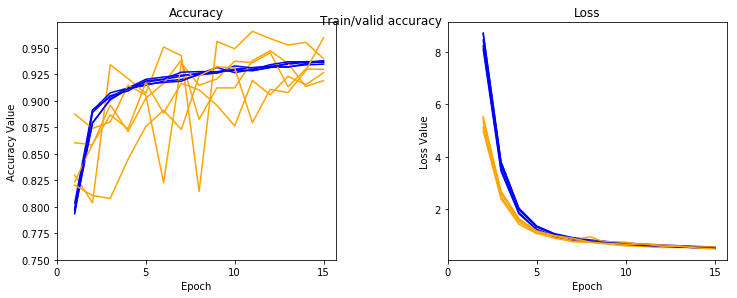

In [254]:
#%run off_sample/utils.py
for fold in range(folds):
    plot_learning_graph(history_list[fold*attempts:(fold+1)*attempts], attempts)
    plt.show()

---